In [ ]:
from google.colab import drive
drive.mount('/content/drive')
work_dir = "<set-current-work-directory-here>"

import os
os.chdir(work_dir)
cwd = os.getcwd().replace("\\", "/")
print(cwd)

In [2]:
def keep_drive_alive():
    drive.mount('/content/drive', force_remount=True)
    os.chdir(work_dir)
    cwd = os.getcwd().replace("\\", "/")
    print(cwd)

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

! pip install transformers wandb
!pip3 install natten -f https://shi-labs.com/natten/wheels/cu118/torch2.0.0/index.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=bb1b26f88e8ba31837ca26e853ff258953ae03048eadf18691e0f6b04add1ff6
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
Looking in links: https://sh

In [5]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import requests
import wandb
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation,UperNetForSemanticSegmentation
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from glob import glob
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    CLAHE,
    HueSaturationValue,
    GaussNoise,
    GridDistortion,
    Compose,
    RandomCrop
)
import cv2
from torch.utils.data import ConcatDataset, DataLoader
from collections import namedtuple
import gc

In [6]:
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [7]:
BATCH_SIZE = 2 # 2 images, that is 1250 patches

kaggle = True if cwd == "/kaggle/working" else False
data_path = "/kaggle/input/" if kaggle else cwd + "/../../data/"

#takes path of x and returns x and y as images
def get_label(x_path):
    x_path = x_path.replace("\\", "/")
    if x_path.__contains__("massachusetts"):
        y_path = x_path.replace("tiff/train/", "tiff/train_labels/").replace(".tiff", ".tif")

    if x_path.__contains__("ethz") or x_path.__contains__("suburbs"):
        y_path = x_path.replace("images/", "groundtruth/")

    if x_path.__contains__("roadsegmentation"):
        y_path = x_path.replace("images/", "groundtruth/").replace(".jpg", ".png")

    if x_path.__contains__("deepglobe"):
        y_path = x_path.replace("sat.jpg", "mask.png")

    return Image.open(x_path), Image.open(y_path)


def save(model, optim, name):
    path = ("/kaggle/working/" if kaggle else "") + name + ".pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
    }, path)


def load(model, optim, name):
    path = ("/kaggle/working/" if kaggle else "") + name + ".pth"
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
# Load the model and setup the classifier head for binary classification
# https://huggingface.co/shi-labs/oneformer_coco_dinat_large
# https://huggingface.co/shi-labs/oneformer_cityscapes_dinat_large
# https://huggingface.co/shi-labs/oneformer_ade20k_dinat_large
# https://huggingface.co/shi-labs/oneformer_ade20k_swin_tiny"

name = "shi-labs/oneformer_cityscapes_dinat_large"

feature_extractor = OneFormerProcessor.from_pretrained(name)
oneformer = OneFormerForUniversalSegmentation.from_pretrained(name)
feature_extractor.image_processor.do_resize = False

In [11]:
# Path Search via Semantic Interpolation in View (PaSSIV) implementation

class Passiv2D(nn.Module):
    def __init__(self, focus_len, img2d_dim, view_units=1, in_channels=1, padding_val=0):
        super().__init__()
        self.focus_len = focus_len
        self.img2d_dim = img2d_dim
        self.view_units = view_units
        assert in_channels == 1
        self.input_in_channels = in_channels
        self.padding_val = padding_val
        self.inf_rad = self.view_units * self.focus_len
        self.inf_dirs = ((-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)) # translated as left, right, top, bottom, main diag (top-left, bottom-right), off-diag (bottom-left, top-right)

        # manually padding the focus patches
        def calc_cost_padding(f, d):
            # f is focus length of the window
            # d is the 2d dim of the images to be used with the operator
            d_pad = [None, None]

            for i, l in enumerate(d):
                if l % f == 0:
                    d_pad[i] = (0, 0)
                    continue
                one_pad = (f-(l%f))//2
                d_pad[i] = (one_pad, f-(l%f) - one_pad)

            return d_pad

        self.img2d_pad = calc_cost_padding(self.focus_len, self.img2d_dim)
        self.const_pad = nn.ConstantPad2d((self.img2d_pad[0][0], self.img2d_pad[0][1], self.img2d_pad[1][0], self.img2d_pad[1][1]), self.padding_val)

        self.focus_conv = nn.Conv2d(self.input_in_channels, self.focus_len, self.focus_len, stride=self.focus_len, padding="valid", dilation=1)
        self.focus_linear = nn.Linear(self.focus_len, 8 * self.focus_len**2)

    def forward(self, x):
        # assume x as (B, C=1, H, W), final output is (B, C=1, H, W)

        pad_x = self.const_pad(x) # (B, C, H_p, W_p)
        B, C, H, W = x.shape
        H_p = pad_x.shape[2]
        W_p = pad_x.shape[3]

        conv_pad_x = self.focus_conv(pad_x) # (B, f, H_p//f, W_p//f)

        view_conv_pad_x = conv_pad_x.view(-1, self.focus_len) # (B*H_p//f*W_p//f, f)
        pad_discounts = nn.functional.sigmoid(self.focus_linear(view_conv_pad_x)).view(-1, 8, H_p, W_p) # (B, 8, H_p, W_p)

        # assert x.shape[0] == pad_discounts.shape[0]

        # fetch the relevant tensors
        slice_pad_discounts = pad_discounts[:, :, self.img2d_pad[1][0]:-self.img2d_pad[1][1] if self.img2d_pad[1][1] !=0 else H, self.img2d_pad[0][0]:-self.img2d_pad[0][1] if self.img2d_pad[0][1] !=0 else W] # (B, 8, H, W)

        order_wise_inf = [] # order times (B, C, H, W)
        for order in range(self.inf_rad):
            if order == 0:
                order_wise_inf.append(x * slice_pad_discounts) # (B, C=1, H, W) times (B, 8, H, W) => (B, 8, H, W)
            else:
                order_wise_inf.append(order_wise_inf[-1]*slice_pad_discounts)

        # mask to select one of the dir_filters
        dir_filters = []
        for dir in range(8):
            dir_filters.append(torch.zeros(B, 8, H, W).cuda())
            dir_filters[-1][:, dir, :, :] += torch.tensor(1).cuda() # (B, 8, H, W)


        out = x
        for order in range(self.inf_rad):
            for dir_ind, dir_coords in enumerate(self.inf_dirs):
                order_wise_inf_flattened = torch.sum(order_wise_inf[order] * dir_filters[dir_ind], axis=1).unsqueeze(1) # (B, 1, H, W)
                rolled_inf = torch.roll(order_wise_inf_flattened, shifts=tuple([(order+1)*d for d in dir_coords]), dims=(-2, -1)) # (B, 1, H, W)

                zero_shift_x = (order + 1)*dir_coords[0]
                zero_shift_y = (order + 1)*dir_coords[1]
                zeros_sq = torch.zeros(B, C, abs(zero_shift_x), abs(zero_shift_y)).cuda()
                zeros_col = torch.zeros(B, C, H-abs(zero_shift_y), abs(zero_shift_x)).cuda()
                zeros_row = torch.zeros(B, C, abs(zero_shift_y), W - abs(zero_shift_x)).cuda()
                ones_sq = torch.ones(B, C, H-abs(zero_shift_y), W - abs(zero_shift_x)).cuda()

                # to parallely apply each dir_filter across many pixels, we use constant masking
                mask_inf = None
                if zero_shift_x > 0 and zero_shift_y > 0:
                    mask_inf = torch.cat([torch.cat([zeros_sq, zeros_row], dim=-1), torch.cat([zeros_col, ones_sq], dim=-1)], dim=-2) # (B, C, H, W)
                elif zero_shift_x > 0 and zero_shift_y < 0:
                    mask_inf = torch.cat([torch.cat([zeros_col, ones_sq], dim=-1), torch.cat([zeros_sq, zeros_row], dim=-1)], dim=-2) # (B, C, H, W)
                elif zero_shift_x < 0 and zero_shift_y > 0:
                    mask_inf = torch.cat([torch.cat([zeros_row, zeros_sq], dim=-1), torch.cat([ones_sq, zeros_col], dim=-1)], dim=-2) # (B, C, H, W)
                elif zero_shift_x < 0 and zero_shift_y < 0:
                    mask_inf = torch.cat([torch.cat([ones_sq, zeros_col], dim=-1), torch.cat([zeros_row, zeros_sq], dim=-1)], dim=-2) # (B, C, H, W)
                elif zero_shift_x > 0 and zero_shift_y == 0:
                    mask_inf = torch.cat([zeros_col, ones_sq], dim=-1) # (B, C, H, W)
                elif zero_shift_x < 0 and zero_shift_y == 0:
                    mask_inf = torch.cat([ones_sq, zeros_col], dim=-1) # (B, C, H, W)
                elif zero_shift_x == 0 and zero_shift_y > 0:
                    mask_inf = torch.cat([zeros_row, ones_sq], dim=-2)
                elif zero_shift_x == 0 and zero_shift_y < 0:
                    mask_inf = torch.cat([ones_sq, zeros_row], dim=-2)

                out = out + mask_inf * rolled_inf # (B, C=1, H, W)

                # legacy code =====
                # for dir in orient:
                #     rolled_inf = torch.roll(order_wise_inf[order], shifts=(order+1)*dir, dims=i+2) # (B, C, H, W)

                #     # calculating the roll mask
                #     zero_partition_dim_size = order + 1
                #     zeros_dim = (B, C, zero_partition_dim_size, W) if i == 0 else (B, C, H, zero_partition_dim_size)
                #     ones_dim = (B, C, H - zero_partition_dim_size, W) if i == 0 else (B, C, H, W - zero_partition_dim_size)

                #     mask_inf = torch.cat([torch.zeros(zeros_dim).cuda(), torch.ones(ones_dim).cuda()], dim=i+2) if dir == 1 else torch.cat([torch.ones(ones_dim).cuda(), torch.zeros(zeros_dim).cuda()], dim=i+2)

                #     out = out + mask_inf * rolled_inf # (B, C, H, W)
                # legacy code =====

        return out # (B, C, H, W)


In [12]:
# # # testing operator

# test_passiv = Passiv2D(48, (400, 400), view_units=1, in_channels=1, padding_val=0).cuda()
# test_input = torch.randn(BATCH_SIZE, 1, 400, 400).cuda()
# test_out = test_passiv(test_input)
# print(test_out.shape)

In [13]:
class CustomModel2(nn.Module):
    def __init__(self, oneformer, oneformer_proc):
        super().__init__()
        self.oneformer = oneformer
        self.proc = oneformer_proc
        self.converter = nn.Sequential(
            nn.Upsample((400, 400), mode='bilinear', align_corners=False),
            nn.Conv2d(150 if name.__contains__("swin") else 250, 1, kernel_size=(1, 1), stride=(1, 1))
        )
        self.infer_from_preds = Passiv2D(80, (400, 400), view_units=1, in_channels=1, padding_val=0)

    def forward(self, x):
        # Semantic Segmentation
        # pixel_values, pixel_mask, task_inputs
        semantic_inputs = self.proc(images=x, task_inputs=["semantic"]*x.shape[0], return_tensors="pt")
        semantic_outputs = self.oneformer(pixel_values=semantic_inputs["pixel_values"].cuda(), task_inputs=semantic_inputs["task_inputs"].cuda(), pixel_mask=semantic_inputs["pixel_mask"].cuda())

        out = self.converter(semantic_outputs.masks_queries_logits)
        out = self.infer_from_preds(out)

        return out


In [14]:
model = CustomModel2(oneformer, feature_extractor)
model = model.cuda()

# print("model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

In [15]:
def get_geometric_transforms_official():
    geometric_transforms = [
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
    ]
    return Compose(geometric_transforms, additional_targets={'mask':'image'})


def get_photometric_transforms():
    return None

In [16]:
return_orig_images = False
class CustomDataset(Dataset):
    def __init__(self, image_files, geometric_transform=None, photometric_transform=None):
        self.image_files = image_files
        self.geometric_transform = geometric_transform
        self.photometric_transform = photometric_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        x_orig, y_orig = get_label(self.image_files[idx])

        x_orig:Image = x_orig.convert("RGB")
        y_orig:Image = y_orig.convert("RGB")

        if x_orig.size[0] == 1024:
            x_orig = x_orig.resize((400, 400))
            y_orig = y_orig.resize((400, 400))

        x_orig_np = np.array(x_orig, dtype=np.uint8)
        y_orig_np = np.array(y_orig, dtype=np.uint8)

        # Apply geometric transforms
        x_augmented, y_augmented = x_orig_np.copy(), y_orig_np.copy()
        if self.geometric_transform:
            augmented = self.geometric_transform(image=x_augmented.copy(), mask=y_augmented.copy())
            x_augmented, y_augmented = augmented['image'], augmented['mask']

        # Apply photometric transforms
        if self.photometric_transform:
            augmented = self.photometric_transform(image=x_augmented.copy())
            x_augmented = augmented['image']

        # allowing feature extraction from within the model so that it can use other outputs of feature extracter
        x = torch.tensor(x_augmented.astype(np.float32), dtype=torch.float32).permute(2, 0, 1).cuda()
        y = torch.tensor((y_augmented.astype(np.float32)/255)[:, :, 0], dtype=torch.float32).unsqueeze(0).cuda()

        if return_orig_images:

            # ensure the orig images have the same size when the datasets are combined
            if x_orig_np.shape[0] == 1500:
                x_orig_np = np.array(Image.fromarray(x_orig_np).resize((400, 400)))
                y_orig_np = np.array(Image.fromarray(y_orig_np).resize((400, 400)))

            # Convert the images to float32
            x_orig_np = x_orig_np.astype(np.float32) / 255
            y_orig_np = y_orig_np.astype(np.float32) / 255
            x_augmented = x_augmented.astype(np.float32) / 255
            y_augmented = y_augmented.astype(np.float32) / 255

            return x, y, self.image_files[idx], x_orig_np, y_orig_np, x_augmented, y_augmented

        else:
            return x, y, self.image_files[idx], torch.zeros(1), torch.zeros(1), torch.zeros(1), torch.zeros(1)



In [17]:
# This is a smaller dataset for weight initialization
googlemaps_dataset = CustomDataset(glob(data_path + "googlemaps-boston-losangeles-suburbs/images/*.png"), get_geometric_transforms_official(), get_photometric_transforms())
googlemaps_loader = DataLoader(googlemaps_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0)

In [18]:
main_dataset_len = len(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))

# Split the dataset
val_size = int(main_dataset_len * 0.1)
train_size = main_dataset_len - val_size
torch.manual_seed(0)
indices = torch.randperm(main_dataset_len).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Apply transformations only on training set
train_dataset = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[train_indices], None, None)
train_dataset_augmented = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[train_indices], get_geometric_transforms_official(), get_photometric_transforms())
val_dataset = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[val_indices], None, None)
val_dataset_augmented = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[val_indices], get_geometric_transforms_official(), get_photometric_transforms())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
val_loader_augmented = DataLoader(val_dataset_augmented, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)

In [19]:
# combine datasets for google+ethz dataset small training
gmaps_official_train_ds_aug = torch.utils.data.ConcatDataset([googlemaps_dataset, train_dataset_augmented])
gmaps_official_train_loader_aug = torch.utils.data.DataLoader(gmaps_official_train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
# for validation we have val_loader_augmented

In [20]:
# Pick a model for x, y
# used from above

In [21]:
def visualize_sample(loader, model=None, rows=4):
    global return_orig_images
    return_orig_images = True

    if model:
        model.eval()

    with torch.no_grad():
        fig, ax = plt.subplots(rows, 5, figsize=(40, 40))
        for i, (x, y, name, x_orig, y_orig, x_augmented, y_augmented) in enumerate(loader):
            x = x[0]
            y = y[0]
            name = name[0]

            x_orig = x_orig[0]
            y_orig = y_orig[0]
            x_augmented = x_augmented[0]
            y_augmented = y_augmented[0]

            if model:
                pred = model(x.unsqueeze(0)).squeeze(0)
                pred = F.sigmoid(pred).permute(1, 2, 0).cpu().numpy()

            y = y.permute(1, 2, 0).cpu().numpy()
            x = x.permute(1, 2, 0).cpu().numpy()

            ax[i][0].imshow(x_orig)
            ax[i][1].imshow(y_orig)
            ax[i][2].imshow(x_augmented)
            ax[i][3].imshow(y_augmented)

            if model:
                ax[i][4].imshow(pred, cmap='gray')

            if i == rows - 1:
                break

    if model:
        model.train()

    return_orig_images = False


In [22]:
# shapes:
# x shape: torch.Size([2, 3, 400, 400]) y shape: torch.Size([2, 1, 400, 400]) x_aug shape: torch.Size([2, 400, 400, 3]) y_aug shape: torch.Size([2, 400, 400, 3])
# BATCH_SIZE_BAK = BATCH_SIZE
# BATCH_SIZE = 1
# visualize_sample(googlemaps_loader, model=model, rows=4)
# BATCH_SIZE = BATCH_SIZE_BAK

In [24]:
# Set up training

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

criterion = nn.BCEWithLogitsLoss()

In [5]:
def plot_epoch_history(e_hist, y_label, plot_sep=False):
    num_epochs = len(e_hist)
    tresh_values = [elem[0] for elem in e_hist[0]]

    tresh_scores = {tresh: [] for tresh in tresh_values}

    for elem in e_hist:
        for score in elem:
            tresh_scores[score[0]].append(score[1])

    if plot_sep:
        result = [tresh for tresh in tresh_values if tresh.startswith('train')]
        train_key = result[0]
        plt.plot(list(range(1, num_epochs+1)), tresh_scores[train_key], label=str(train_key))
        plt.legend()
        plt.xlabel("Epochs-->")
        plt.ylabel(y_label)
        plt.show()

        for tresh in tresh_values:
            if tresh == train_key:
                continue
            plt.plot(list(range(1, num_epochs+1)), tresh_scores[tresh], label=str(tresh))

        plt.legend()
        plt.xlabel("Epochs-->")
        plt.ylabel(y_label)
        plt.show()

    else:
        for tresh in tresh_values:
            plt.plot(list(range(1, num_epochs+1)), tresh_scores[tresh], label=str(tresh))

        plt.legend()
        plt.xlabel("Epochs-->")
        plt.ylabel(y_label)
        plt.show()

In [26]:
use_wandb = False

def train(model, dataset, optimizer):
    torch.backends.cudnn.benchmark = True
    model.train()
    total_loss = 0
    steps = 0
    for x, y, _a, _b, _c, _d, _e in tqdm(dataset):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        steps += 1
        if steps % 100 == 0:
            print("Training Loss:", total_loss / steps)
            if use_wandb: wandb.log({"Train Loss": total_loss / steps})

    print("Training Loss:", total_loss / len(dataset))
    if use_wandb: wandb.log({"Train Loss": total_loss / len(dataset)})
    return ("train_loss", total_loss / len(dataset))

In [27]:
def validate(model, dataset):
    model.eval()
    y_preds = np.array([], dtype=np.float32)
    y_gt = np.array([], dtype=np.float32)
    with torch.no_grad():
        for x, y, _a, _b, _c, _d, _e in dataset:
            x, y = x.cuda(), y.cuda()
            y_pred = model(x)
            y_pred = torch.sigmoid(y_pred)

            # apply pooling to reduce the prediction from 400x400 to 25x25
            y_pred = F.avg_pool2d(y_pred, 16, stride=16)
            # apply pooling to reduce the label from 400x400 to 25x25
            y = F.avg_pool2d(y, 16, stride=16)

            y_preds = np.concatenate((y_preds, y_pred.cpu().numpy().flatten()))
            y_gt = np.concatenate((y_gt, y.cpu().numpy().flatten()))


    y_preds = np.array(y_preds)
    y_gt = np.array(y_gt)
    max_res = (0.0,0.0)
    tresh_scores = []

    for tresh in np.arange(0.15,0.40,0.05):
        score = f1_score(y_gt>0.25, y_preds > tresh)
        print("Validation F1 Score for tresh",tresh,":", score)
        if use_wandb: wandb.log("Validation F1 Score for tresh "+str(tresh) +": " + str(score))
        if score > max_res[1]:
            max_res = (tresh, score)
        tresh_scores.append(("val_thresh = " + str(round(tresh, 3)), score))

    return max_res, tresh_scores


In [28]:
# fine-tuning cell, to be used if needed

# train the classification head and the last block
for param in model.oneformer.parameters():
    param.requires_grad = False
for param in model.oneformer.model.transformer_module.decoder.parameters():
    param.requires_grad = True

# for param in mode.parameters():
#     param.requires_grad = True

# print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [29]:
epoch_history = []

In [ ]:
# DS: gmaps_official_train_loader_aug, train_loader_augmented

max_epoch_val_score = (0.0, 0.0, 0.0)
num_epochs = 160

for epoch in range(num_epochs):
    history_elem = []
    # preserve drive session
    if (epoch+1)%(int(0.4*num_epochs)) == 0:
        keep_drive_alive()
    print("Results for Epoch:", epoch)
    train_loss = train(model, train_loader_augmented, optimizer)
    history_elem.append(train_loss)
    res, val_scores = validate(model, val_loader)
    history_elem = history_elem + val_scores
    if res[1] > max_epoch_val_score[2]:
        max_epoch_val_score = (epoch, res[0], res[1])
        if max_epoch_val_score[2] > 0.66: # 0.66
            save(model, optimizer, "model_epoch_" + str(epoch) + "__ft_passiv_oneformer_focus_48__official_aug__lr_1em4_epochs_250")

    print("Max Epoch Score:", max_epoch_val_score)
    epoch_history.append(history_elem)
plot_epoch_history(epoch_history, "Loss/F1-Scores", plot_sep=False)

In [33]:
# dumping epoch history

with open('history__ft_passiv_oneformer_focus_48__official_aug__lr_1em4_epochs_250.pkl', 'wb') as f:
    pickle.dump(epoch_history, f)

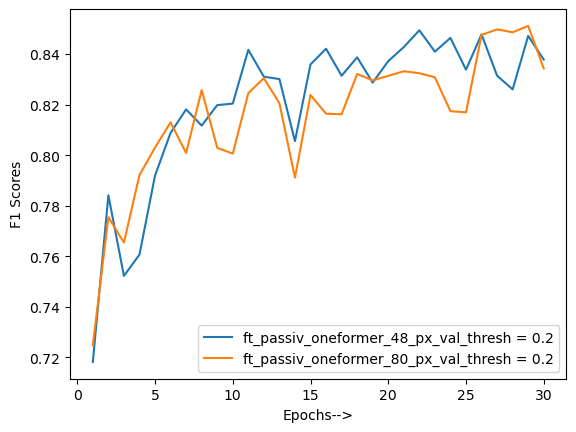

In [64]:
# Util to plot multiple epoch histories (use when needed)

epoch_histories = [epoch_history, epoch_history]
escape_keys = ["loss",  "0.35", "0.25", "0.15", "0.3"] # keys not to plot
epoch_lim = 30 # epoch till which we need the plot

def plot_epoch_histories(epoch_histories, legend_prefixes, y_label):
    for i, e_hist in enumerate(epoch_histories):
        num_epochs = len(e_hist)
        tresh_values = [elem[0] for elem in e_hist[0]]

        tresh_scores = {tresh: [] for tresh in tresh_values}

        for elem in e_hist:
            for score in elem:
                tresh_scores[score[0]].append(score[1])

        for tresh in tresh_values:
            if any(tresh.endswith(esc_key) for esc_key in escape_keys):
                continue
            plt.plot(list(range(1, num_epochs+1))[:epoch_lim], tresh_scores[tresh][:epoch_lim], label=str(legend_prefixes[i]) + "_" + str(tresh))

    plt.legend()
    plt.xlabel("Epochs-->")
    plt.ylabel(y_label)
    plt.show()

plot_epoch_histories(epoch_histories, ["ft_passiv_oneformer_48_px", "ft_passiv_oneformer_80_px"], "F1 Scores")

In [ ]:
BATCH_SIZE_BAK = BATCH_SIZE
BATCH_SIZE = 1
visualize_sample(googlemaps_loader, model=model, rows=4)
BATCH_SIZE = BATCH_SIZE_BAK

In [29]:
load(model, optimizer, "model_epoch_101__pt_passiv_oneformer_focus_48__official_aug__lr_1em4_epochs_250")
optimizer.param_groups[0]['lr'] = 1e-4

In [ ]:
if use_wandb: wandb.finish()

In [ ]:
# predicted image files for test set
BATCH_SIZE_BAK = BATCH_SIZE
BATCH_SIZE = 1
with torch.no_grad():
    test_path = data_path + "ethz-cil-road-segmentation-2023/" + "test/images/"
    model.eval()
    files = os.listdir(test_path)
    for file in tqdm(files):
        x_orig:Image = Image.open(test_path + file).convert("RGB")
        x_orig = np.array(x_orig, dtype=np.float32)
        x = torch.tensor(x_orig.astype(np.float32), dtype=torch.float32).permute(2, 0, 1).cuda()
        pred = model(x.unsqueeze(0))
        pred = pred.squeeze(0)
        pred = torch.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
        pred = pred.squeeze(-1)
        pred = Image.fromarray((pred*255).astype(np.uint8))

        output_dir = "test_preds/"
        #make the folder
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        pred.save(output_dir + file)

BATCH_SIZE = BATCH_SIZE_BAK

100%|██████████| 144/144 [00:32<00:00,  4.39it/s]


In [ ]:
# zip the folder
import shutil
shutil.make_archive("test_preds/", 'zip', output_dir+"/../")